In [2]:
from pyvis import network as net
import networkx as nx
import sklearn
import graphviz

In [3]:
# python ######################################################################
import os
import sys
import datetime

# basics ######################################################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# widgets #####################################################################
import ipywidgets as widgets
from ipywidgets import interact

# process mining ##############################################################
import pm4py

# object.log
from pm4py.objects.log.util import dataframe_utils
#from pm4py.objects.log.exporter.xes import exporter as xes_exporter
#from pm4py.objects.log.importer.xes import importer as xes_importer

# object.conversion
from pm4py.objects.conversion.dfg import converter as dfg_converter
from pm4py.objects.conversion.process_tree import converter as pt_converter

# algo.discovery
from pm4py.algo.discovery.alpha import variants
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner

# algo.conformance
from pm4py.algo.conformance.tokenreplay import algorithm as token_replay

# vizualization
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.visualization.dfg import visualizer as dfg_visualization
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer

In [4]:
# Loading Event Data
df = pd.read_csv('BPI Challenge 2017.csv', parse_dates = ['Start Timestamp', 'Complete Timestamp'])

# format Dataframe
df = pm4py.format_dataframe(
    df,
    case_id = 'Case ID',
    activity_key = 'Activity',
    timestamp_key = 'Complete Timestamp', 
    start_timestamp_key = 'Start Timestamp',
    timest_format = '%Y-%m-%d %H:%M:%S%z'
)

# Dimentions of Event Data
df.shape

(1160405, 27)

In [5]:
# Check NA-values
df.isna().sum()

Case ID                        0
Activity                       0
Resource                       0
Start Timestamp                0
Complete Timestamp             0
Variant                        0
Variant index                  0
lifecycle:transition           0
EventOrigin                    0
EventID                        0
Action                         0
LoanGoal                       0
ApplicationType                0
RequestedAmount                0
FirstWithdrawalAmount    1117410
NumberOfTerms            1117410
Accepted                 1117410
MonthlyCost              1117410
Selected                 1117410
CreditScore              1117410
OfferedAmount            1117410
OfferID                  1009551
case:concept:name              0
concept:name                   0
time:timestamp                 0
@@index                        0
start_timestamp                0
dtype: int64

In [6]:
df.columns

Index(['Case ID', 'Activity', 'Resource', 'Start Timestamp',
       'Complete Timestamp', 'Variant', 'Variant index',
       'lifecycle:transition', 'EventOrigin', 'EventID', 'Action', 'LoanGoal',
       'ApplicationType', 'RequestedAmount', 'FirstWithdrawalAmount',
       'NumberOfTerms', 'Accepted', 'MonthlyCost', 'Selected', 'CreditScore',
       'OfferedAmount', 'OfferID', 'case:concept:name', 'concept:name',
       'time:timestamp', '@@index', 'start_timestamp'],
      dtype='object')

In [7]:
# Deleting culumns of Event data that have NAs or are useless in this Project
df = df.drop(['FirstWithdrawalAmount', 'NumberOfTerms', 'Accepted', 'MonthlyCost',
'Selected', 'CreditScore', 'OfferedAmount', 'OfferID'], axis=1)

# First 5 rows in Eent Data
df.head()

,Case ID,Activity,Resource,Start Timestamp,Complete Timestamp,Variant,Variant index,lifecycle:transition,EventOrigin,EventID,Action,LoanGoal,ApplicationType,RequestedAmount,case:concept:name,concept:name,time:timestamp,@@index,start_timestamp
661035,Application_1000086665,A_Create Application,User_1,2016-08-03 19:27:21.673,2016-08-03 19:27:21.673,Variant 3,3,complete,Application,Application_1000086665,Created,"Other, see explanation",New credit,5000.0,Application_1000086665,A_Create Application,2016-08-03 19:27:21.673,661035,2016-08-03 19:27:21.673
661036,Application_1000086665,A_Submitted,User_1,2016-08-03 19:27:21.734,2016-08-03 19:27:21.734,Variant 3,3,complete,Application,ApplState_161925113,statechange,"Other, see explanation",New credit,5000.0,Application_1000086665,A_Submitted,2016-08-03 19:27:21.734,661036,2016-08-03 19:27:21.734
661037,Application_1000086665,W_Handle leads,User_1,2016-08-03 19:27:21.963,2016-08-03 19:27:21.963,Variant 3,3,schedule,Workflow,Workitem_747707399,Created,"Other, see explanation",New credit,5000.0,Application_1000086665,W_Handle leads,2016-08-03 19:27:21.963,661037,2016-08-03 19:27:21.963
661038,Application_1000086665,W_Handle leads,User_1,2016-08-03 19:28:28.286,2016-08-03 19:28:28.286,Variant 3,3,withdraw,Workflow,Workitem_1030261128,Deleted,"Other, see explanation",New credit,5000.0,Application_1000086665,W_Handle leads,2016-08-03 19:28:28.286,661038,2016-08-03 19:28:28.286
661039,Application_1000086665,W_Complete application,User_1,2016-08-03 19:28:28.293,2016-08-03 19:28:28.293,Variant 3,3,schedule,Workflow,Workitem_1127124826,Created,"Other, see explanation",New credit,5000.0,Application_1000086665,W_Complete application,2016-08-03 19:28:28.293,661039,2016-08-03 19:28:28.293


In [8]:
df.shape

(1160405, 19)

In [9]:
# Unique values
pd.DataFrame(
    {
        'variable': df.columns, 
        'unique values': [df[col].nunique() for col in df.columns],
        'fraction': [round(df[col].nunique() / df.shape[0], 2) for col in df.columns], 
    }
).set_index('variable')

,unique values,fraction
variable,,
Case ID,31509,0.03
Activity,26,0.00
Resource,149,0.00
Start Timestamp,1160354,1.00
Complete Timestamp,1160348,1.00
Variant,15484,0.01
Variant index,15484,0.01
lifecycle:transition,7,0.00
EventOrigin,3,0.00


In [10]:
# Convert to Event log
log = pm4py.convert_to_event_log(df)

## Statistics

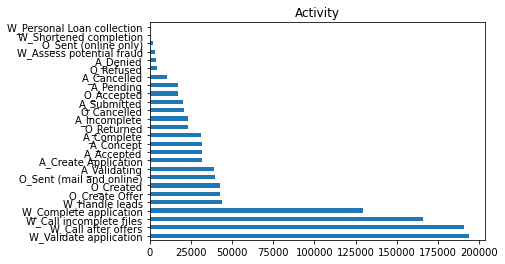

In [11]:
# Value counts: activity
df['concept:name'].value_counts().plot(y='concept:name', kind='barh', title='Activity')
plt.show()

In [12]:
# Case Arrival/Dispersion Ratio
case_arrival_ratio = pm4py.get_case_arrival_average(log)
from pm4py.statistics.traces.generic.log import case_arrival
case_dispersion_ratio = case_arrival.get_case_dispersion_avg(log, parameters={
    case_arrival.Parameters.TIMESTAMP_KEY: "time:timestamp"})
case_dispersion_ratio

1075.538232226736

In [13]:
# Business Hours
from pm4py.util.business_hours import BusinessHours
from datetime import datetime

st = datetime.fromtimestamp(100000000)
et = datetime.fromtimestamp(200000000)
bh_object = BusinessHours(st, et)
worked_time = bh_object.getseconds()
print(worked_time)
bh_object = BusinessHours(st, et, worktiming=[10, 16], weekends=[5, 6, 7])
worked_time = bh_object.getseconds()
print(worked_time)

29736000.0
14277600.0


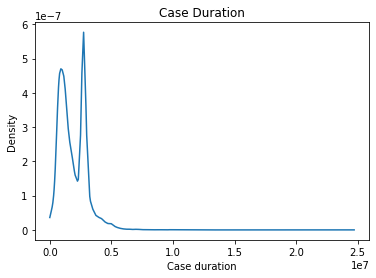

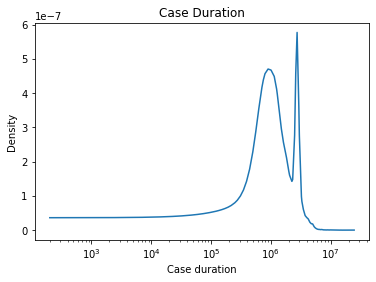

In [14]:
# Distribution of case duration
from pm4py.util import constants
from pm4py.statistics.traces.generic.log import case_statistics
x, y = case_statistics.get_kde_caseduration(log, parameters={constants.PARAMETER_CONSTANT_TIMESTAMP_KEY: "time:timestamp"})

from pm4py.visualization.graphs import visualizer as graphs_visualizer

gviz = graphs_visualizer.apply_plot(x, y, variant=graphs_visualizer.Variants.CASES)
graphs_visualizer.view(gviz)

gviz = graphs_visualizer.apply_semilogx(x, y, variant=graphs_visualizer.Variants.CASES)
graphs_visualizer.view(gviz)

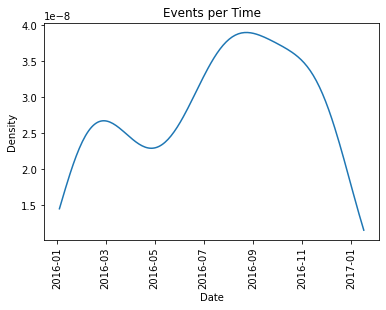

In [15]:
# Distribution of events over time
from pm4py.algo.filtering.log.attributes import attributes_filter

x, y = attributes_filter.get_kde_date_attribute(log, attribute="time:timestamp")

from pm4py.visualization.graphs import visualizer as graphs_visualizer

gviz = graphs_visualizer.apply_plot(x, y, variant=graphs_visualizer.Variants.DATES)
graphs_visualizer.view(gviz)

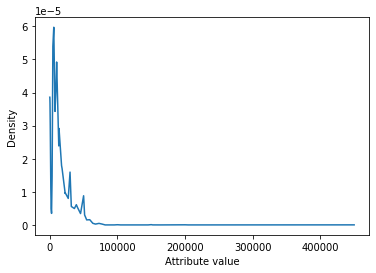

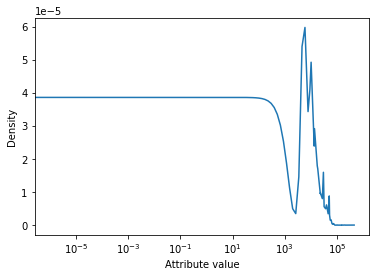

In [16]:
# Distribution of a numeric attribute
from pm4py.algo.filtering.log.attributes import attributes_filter

x, y = attributes_filter.get_kde_numeric_attribute(log, "RequestedAmount")

from pm4py.visualization.graphs import visualizer as graphs_visualizer

gviz = graphs_visualizer.apply_plot(x, y, variant=graphs_visualizer.Variants.ATTRIBUTES)
graphs_visualizer.view(gviz)

from pm4py.visualization.graphs import visualizer as graphs_visualizer

gviz = graphs_visualizer.apply_semilogx(x, y, variant=graphs_visualizer.Variants.ATTRIBUTES)
graphs_visualizer.view(gviz)

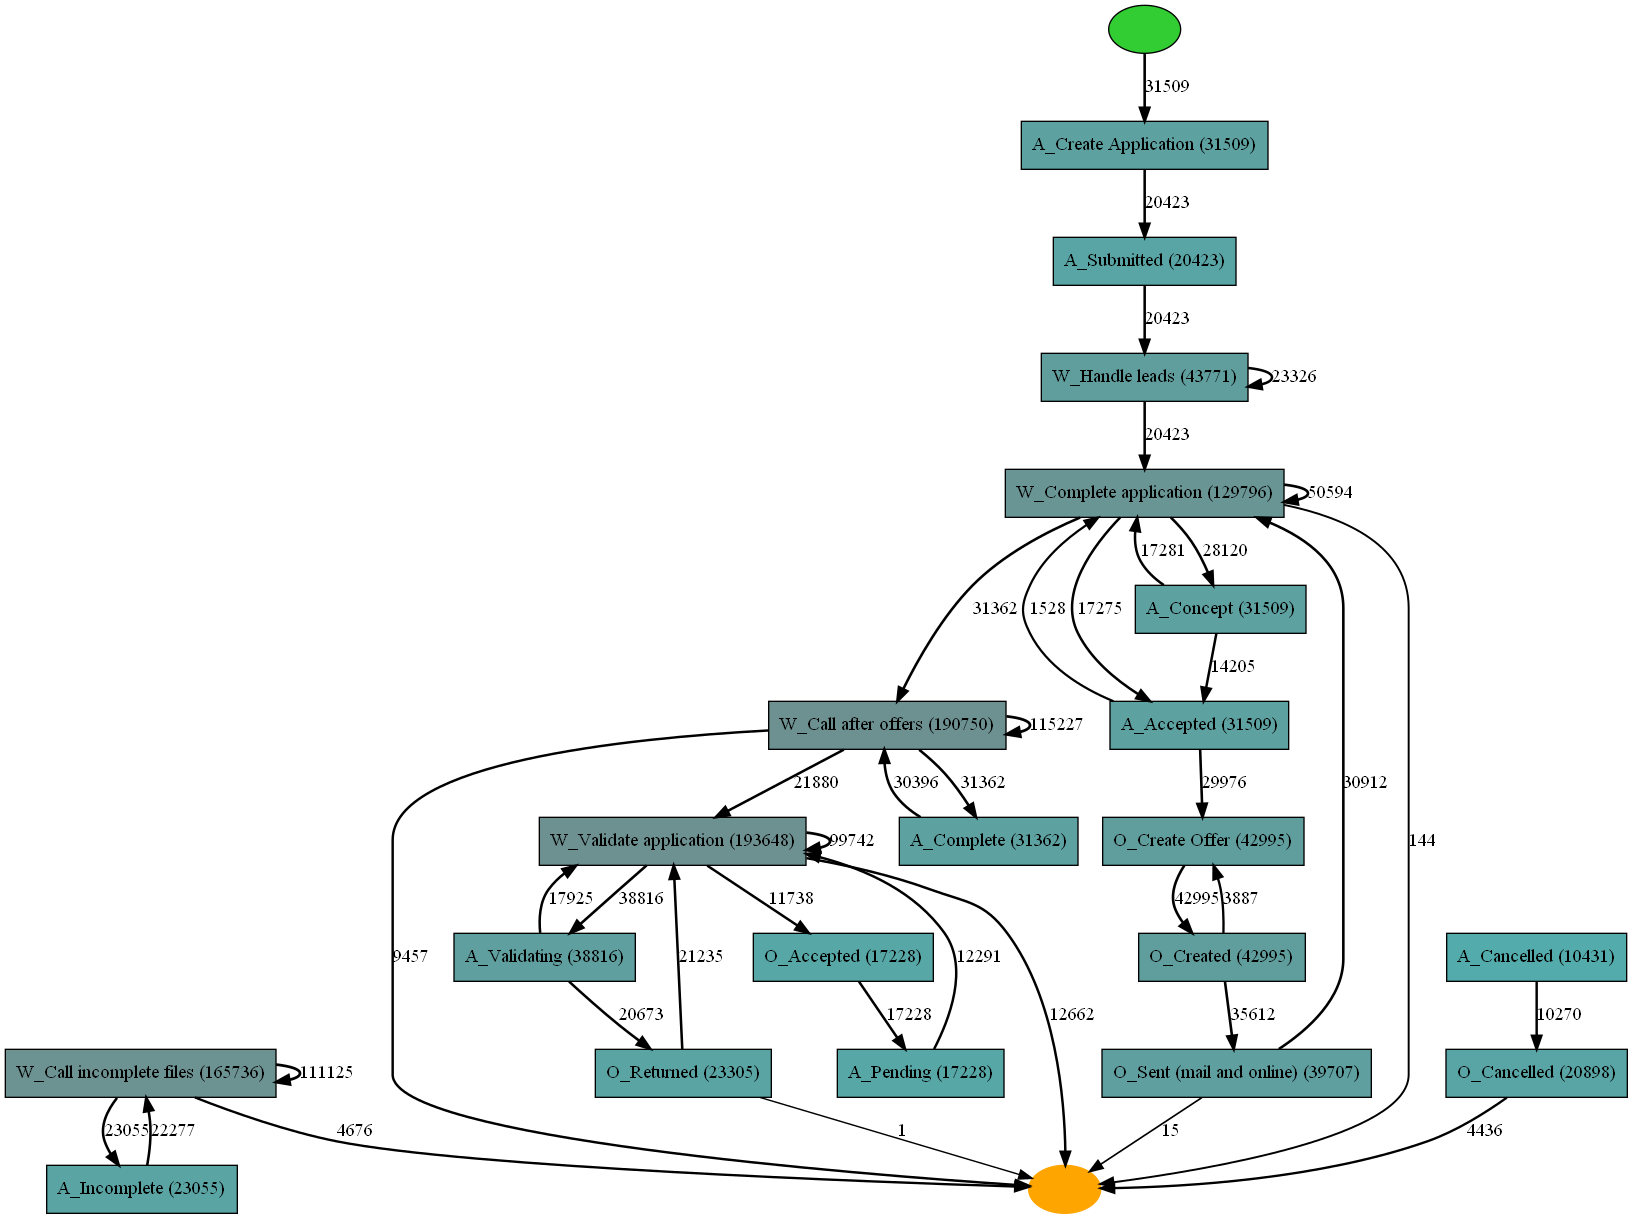

In [17]:
# Simplified Interface
heu_net = pm4py.discover_heuristics_net(
    log, dependency_threshold=0.9999, 
    and_threshold=0.999, 
    loop_two_threshold=0.999
)
pm4py.save_vis_heuristics_net(heu_net, file_path='heuristicsminer.png') 
pm4py.view_heuristics_net(heu_net)

In [18]:
# Start Activities
start_activities = pm4py.get_start_activities(df)
start_activities

{'A_Create Application': 31509}

In [19]:
# End Activities
end_activities = pm4py.get_end_activities(df)
end_activities

{'W_Validate application': 12662,
 'W_Call after offers': 9457,
 'W_Call incomplete files': 4676,
 'O_Cancelled': 4436,
 'W_Complete application': 144,
 'W_Assess potential fraud': 102,
 'O_Sent (mail and online)': 15,
 'O_Sent (online only)': 8,
 'W_Shortened completion': 5,
 'W_Personal Loan collection': 2,
 'A_Denied': 1,
 'O_Returned': 1}

## RQ1: Throughput Time

In [20]:
complete_single_offer = pm4py.filter_end_activities(log, ['W_Validate application'])
complete_multiple_offer = pm4py.filter_end_activities(log, ['O_Cancelled'])
cancelled = pm4py.filter_event_attribute_values(log, 'Activity', 'A_Cancelled')
denied = pm4py.filter_event_attribute_values(log, 'Activity', 'O_Refused')

In [21]:
subsets = [complete_single_offer, complete_multiple_offer, cancelled, denied]
throughput = pd.DataFrame(
    {
        'Application Case Type': ['complete_single_offer', 'complete_multiple_offer', 'cancelled', 'denied'],
        'Throughput Time': [np.mean(pm4py.get_all_case_durations(i)) / 86400  for i in subsets],
        'Cases': [len(i) for i in subsets],
        'fraction': [len(i) / len(log) for i in subsets ]
    }
)
throughput

,Application Case Type,Throughput Time,Cases,fraction
0,complete_single_offer,15.285979,12662,0.401853
1,complete_multiple_offer,23.510446,4436,0.140785
2,cancelled,29.887714,10431,0.331048
3,denied,16.877526,3720,0.118062


In [22]:
throughput = pd.DataFrame(
    {
        'Application Case Type': ['complete_single_offer', 'complete_multiple_offer', 'cancelled', 'denied'],
        'Car': [len(pm4py.filter_event_attribute_values(i, 'LoanGoal', 'Car')) / len(i) for i in subsets],
        'Home Improvement': [len(pm4py.filter_event_attribute_values(i, 'LoanGoal', 'Home improvement')) / len(i) for i in subsets],
        'Existing Loan Takeover': [len(pm4py.filter_event_attribute_values(i, 'LoanGoal', 'Existing loan takeover')) / len(i) for i in subsets]
    }
)
throughput

,Application Case Type,Car,Home Improvement,Existing Loan Takeover
0,complete_single_offer,0.288817,0.246722,0.176118
1,complete_multiple_offer,0.269612,0.248647,0.201984
2,cancelled,0.325664,0.222222,0.164222
3,denied,0.300538,0.222581,0.209409


## RQ2: applicant-system interaction

In [23]:
# Total number of calls for completion
called = pm4py.filter_event_attribute_values(log, 'Activity', 'W_Call incomplete files')
print('Total cases with at least one call for completion: %s\n Percentage: %5.2f' %(len(called), len(called)/len(log)*100))

Total cases with at least one call for completion: 15003
 Percentage: 47.61


In [24]:
tot_called = pm4py.filter_event_attribute_values(log, 'Activity', ['W_Call incomplete files'], 'event')
len(tot_called)

15003

In [25]:
def call_case_counter (event_log, n) :
    count = 0
    for case in event_log :
        if len(case) == n :
            count += 1
    return count

call_case_counter(tot_called, 2)

72

In [26]:
pd.DataFrame(tot_called[800])

,@@index,Action,Activity,ApplicationType,Case ID,Complete Timestamp,EventID,EventOrigin,LoanGoal,RequestedAmount,Resource,Start Timestamp,Variant,Variant index,concept:name,lifecycle:transition,start_timestamp,time:timestamp
0,670200,Created,W_Call incomplete files,New credit,Application_110222905,2016-08-12 12:26:16.989,Workitem_826578232,Workflow,Caravan / Camper,20000.0,User_122,2016-08-12 12:26:16.989,Variant 10005,10005,W_Call incomplete files,schedule,2016-08-12 12:26:16.989,2016-08-12 12:26:16.989
1,670201,Obtained,W_Call incomplete files,New credit,Application_110222905,2016-08-12 12:26:16.992,Workitem_1901540902,Workflow,Caravan / Camper,20000.0,User_122,2016-08-12 12:26:16.992,Variant 10005,10005,W_Call incomplete files,start,2016-08-12 12:26:16.992,2016-08-12 12:26:16.992
2,670203,Released,W_Call incomplete files,New credit,Application_110222905,2016-08-12 12:28:23.265,Workitem_707202871,Workflow,Caravan / Camper,20000.0,User_122,2016-08-12 12:28:23.265,Variant 10005,10005,W_Call incomplete files,suspend,2016-08-12 12:28:23.265,2016-08-12 12:28:23.265
3,670204,Obtained,W_Call incomplete files,New credit,Application_110222905,2016-08-12 13:38:57.217,Workitem_369189445,Workflow,Caravan / Camper,20000.0,User_54,2016-08-12 13:38:57.217,Variant 10005,10005,W_Call incomplete files,resume,2016-08-12 13:38:57.217,2016-08-12 13:38:57.217
4,670205,Released,W_Call incomplete files,New credit,Application_110222905,2016-08-12 13:39:57.134,Workitem_2076621754,Workflow,Caravan / Camper,20000.0,User_54,2016-08-12 13:39:57.134,Variant 10005,10005,W_Call incomplete files,suspend,2016-08-12 13:39:57.134,2016-08-12 13:39:57.134
5,670206,Deleted,W_Call incomplete files,New credit,Application_110222905,2016-08-13 13:12:11.585,Workitem_475726293,Workflow,Caravan / Camper,20000.0,User_122,2016-08-13 13:12:11.585,Variant 10005,10005,W_Call incomplete files,ate_abort,2016-08-13 13:12:11.585,2016-08-13 13:12:11.585


## RQ3: Conversion Rate

In [27]:
# delete application and workflow events
Offer_log = pm4py.filter_event_attribute_values(log, 'EventOrigin', 'Offer', 'event')
created_offer = pm4py.filter_event_attribute_values(log, 'Activity', 'O_Created', 'event')
len(created_offer)

31509

In [28]:
def offer_counter (event_log, n) :
    count = 0
    for case in event_log :
        if len(case) == n :
            count += 1
    return count

offer_counter(created_offer, 2)

6578

In [29]:
offer_made = {'': ['N. of Offers', 'Perc of Offers']}

for i in range(1, 11) :
    offer_made[i] = [offer_counter(created_offer, i), round((offer_counter(created_offer, i) / len(log) *100), 2)]

pd.DataFrame(offer_made)


,,1,2,3,4,5,6,7,8,9,10
0,N. of Offers,22950.00,6578.00,1348.00,443.00,126.0,30.0,16.00,13.00,3.00,2.00
1,Perc of Offers,72.84,20.88,4.28,1.41,0.4,0.1,0.05,0.04,0.01,0.01


## RQ4: Customer Behavior

In [30]:
cancelled = pm4py.filter_event_attribute_values(log, 'Activity', 'A_Cancelled')
len(cancelled)

10431

In [33]:
df.columns

Index(['Case ID', 'Activity', 'Resource', 'Start Timestamp',
       'Complete Timestamp', 'Variant', 'Variant index',
       'lifecycle:transition', 'EventOrigin', 'EventID', 'Action', 'LoanGoal',
       'ApplicationType', 'RequestedAmount', 'case:concept:name',
       'concept:name', 'time:timestamp', '@@index', 'start_timestamp'],
      dtype='object')

In [34]:
df_ = df.copy()
df_.rename(columns = {'Resource' : 'org:resource'}, inplace = True)

In [35]:
# Clustering
sa_metric = pm4py.discover_activity_based_resource_similarity(df_)
from pm4py.algo.organizational_mining.sna import util
clustering = util.cluster_affinity_propagation(sa_metric)
clustering

{'2': ['User_1', 'User_138', 'User_143', 'User_144', 'User_147'],
 '4': ['User_10',
  'User_13',
  'User_141',
  'User_15',
  'User_16',
  'User_17',
  'User_18',
  'User_19',
  'User_21',
  'User_24',
  'User_35',
  'User_36',
  'User_37',
  'User_38',
  'User_4',
  'User_40',
  'User_42',
  'User_44',
  'User_45',
  'User_46',
  'User_47',
  'User_49',
  'User_51',
  'User_60',
  'User_61',
  'User_62',
  'User_70',
  'User_74',
  'User_84',
  'User_85',
  'User_92'],
 '0': ['User_100',
  'User_101',
  'User_102',
  'User_107',
  'User_109',
  'User_115',
  'User_124',
  'User_128',
  'User_129',
  'User_136',
  'User_139',
  'User_148',
  'User_29',
  'User_30',
  'User_68',
  'User_75',
  'User_83',
  'User_90',
  'User_95',
  'User_99'],
 '3': ['User_103',
  'User_104',
  'User_105',
  'User_108',
  'User_110',
  'User_12',
  'User_132',
  'User_135',
  'User_20',
  'User_22',
  'User_25',
  'User_32',
  'User_43',
  'User_50',
  'User_55',
  'User_56',
  'User_57',
  'User_59',
 